 Starting MMM Data Simulation...
Simulating media spend channels...
 Simulating competitor spend...
 Simulating seasonality patterns...
Simulating trend and control variables...
 Simulating time-varying media effects...
Simulating cross-channel interactions...
 Simulating outcome variable...
 Creating final dataset...
 Simulation Complete!
Dataset shape: (156, 23)
Time period: 2020-01-01 to 2022-12-25
Media channels: 5
 Competitor channels: 2

SIMULATION SUMMARY STATISTICS
Outcome Statistics:
   Mean: 1244.26
   Std:  101.28
   Min:  1065.86
   Max:  1656.28

 Media Spend Statistics:
   TV: Mean=1938, Std=1320
   Social: Mean=1806, Std=888
   Search: Mean=1472, Std=659
   Display: Mean=905, Std=500
   Radio: Mean=1314, Std=762

 Competitor Spend Statistics:
   Competitor_TV: Mean=1885, Std=1142
   Competitor_Digital: Mean=1911, Std=1006

Media Contribution Statistics:
   TV: Mean=0.27, Std=0.05
   Social: Mean=0.21, Std=0.01
   Search: Mean=0.16, Std=0.01
   Display: Mean=0.14, Std=0.0

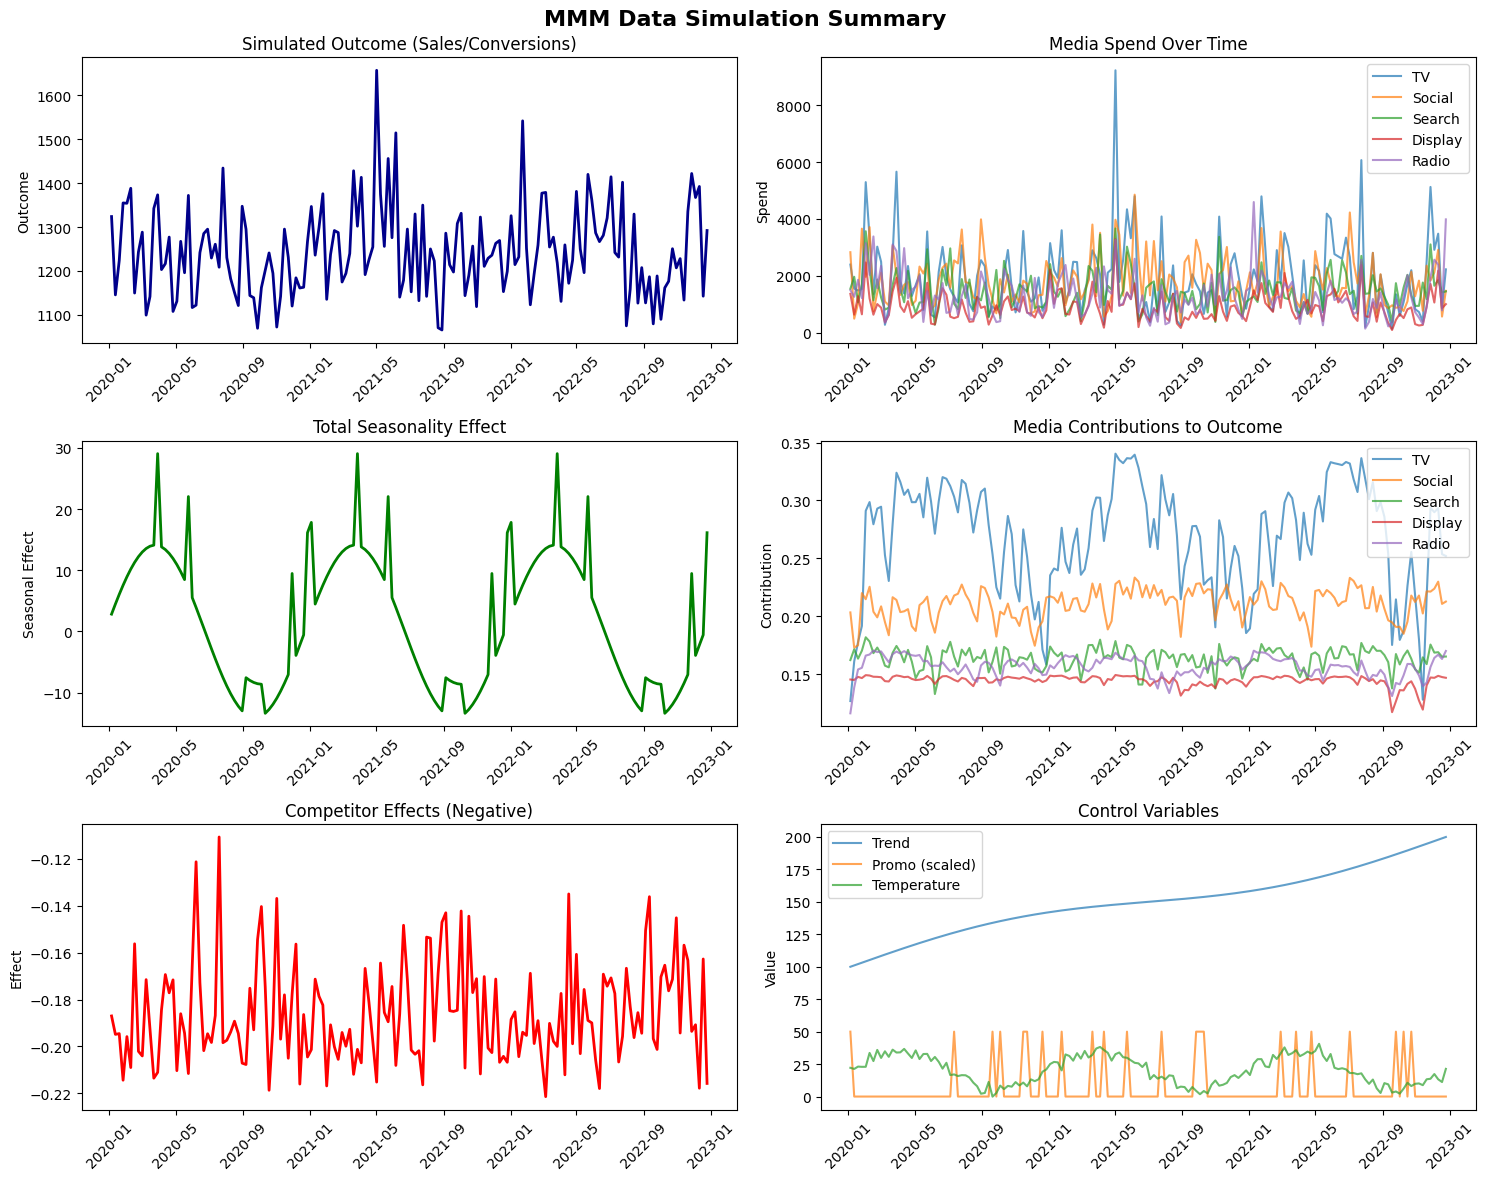


 Dataset saved as 'mmm_simulated_data.csv'

 Metadata:
   media_channels: ['TV', 'Social', 'Search', 'Display', 'Radio']
   competitor_channels: ['Competitor_TV', 'Competitor_Digital']
   control_variables: ['trend', 'inflation', 'unemployment', 'promo', 'price_index', 'temperature', 'special_events']
   seasonality_components: ['weekly', 'annual', 'holiday', 'back_to_school']
   interaction_effects: ['TV_Social_synergy', 'Search_Social_synergy', 'Search_Display_cannibalization']
   time_period: 2020-01-01 to 2022-12-25
   frequency: W
   periods: 156


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import gamma, beta
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class MMDataSimulator:
    """
    Complete Marketing Mix Model Data Simulator
    Generates realistic marketing data with all MMM features
    """
    
    def __init__(self, start_date="2020-01-01", periods=156, freq="W"):
        """
        Initialize the simulator
        
        Parameters:
        -----------
        start_date : str
            Start date for the time series
        periods : int
            Number of time periods to simulate
        freq : str
            Frequency ('W' for weekly, 'D' for daily)
        """
        self.start_date = start_date
        self.periods = periods
        self.freq = freq
        self.date_range = pd.date_range(start=start_date, periods=periods, freq=freq)
        self.n = len(self.date_range)
        
        # Initialize containers
        self.media_channels = {}
        self.competitor_spend = {}
        self.control_variables = {}
        self.seasonality_components = {}
        self.time_varying_effects = {}
        
    def simulate_media_spend(self):
        """Generate media spend data for multiple channels"""
        print("Simulating media spend channels...")
        
        # Base spend patterns with different distributions
        self.media_channels = {
            "TV": gamma.rvs(a=2, scale=1000, size=self.n) * (1 + 0.3 * np.sin(2 * np.pi * np.arange(self.n) / 52)),
            "Social": gamma.rvs(a=2.5, scale=500, size=self.n) * (1 + 0.2 * np.cos(2 * np.pi * np.arange(self.n) / 26)),
            "Search": gamma.rvs(a=3, scale=300, size=self.n) * (1 + 0.15 * np.sin(2 * np.pi * np.arange(self.n) / 13)),
            "Display": gamma.rvs(a=1.5, scale=200, size=self.n) * (1 + 0.25 * np.sin(2 * np.pi * np.arange(self.n) / 52 + np.pi/4)),
            "Radio": gamma.rvs(a=1.8, scale=400, size=self.n) * (1 + 0.4 * np.sin(2 * np.pi * np.arange(self.n) / 52 + np.pi/2))
        }
        
        # Add some correlation between channels (realistic media planning)
        correlation_factor = 0.3
        for i, channel in enumerate(list(self.media_channels.keys())[1:], 1):
            noise = np.random.normal(0, 0.1, self.n)
            self.media_channels[channel] += correlation_factor * self.media_channels["TV"] + noise
        
        # Ensure non-negative spending
        for channel in self.media_channels:
            self.media_channels[channel] = np.maximum(self.media_channels[channel], 0)
    
    def simulate_competitor_spend(self):
        """Generate competitor spend data"""
        print(" Simulating competitor spend...")
        
        self.competitor_spend = {
            "Competitor_TV": gamma.rvs(a=2, scale=800, size=self.n) * (1 + 0.2 * np.sin(2 * np.pi * np.arange(self.n) / 52 + np.pi/3)),
            "Competitor_Digital": gamma.rvs(a=2.2, scale=600, size=self.n) * (1 + 0.15 * np.cos(2 * np.pi * np.arange(self.n) / 26))
        }
        
        # Competitors react to our spend (competitive dynamics)
        reaction_factor = 0.2
        self.competitor_spend["Competitor_TV"] += reaction_factor * self.media_channels["TV"]
        self.competitor_spend["Competitor_Digital"] += reaction_factor * (self.media_channels["Social"] + self.media_channels["Display"])
        
        # Ensure non-negative
        for channel in self.competitor_spend:
            self.competitor_spend[channel] = np.maximum(self.competitor_spend[channel], 0)
    
    def make_fourier_terms(self, t, period, order):
        """Generate Fourier series terms for seasonality"""
        return np.column_stack([
            func(2 * np.pi * k * t / period)
            for k in range(1, order + 1)
            for func in (np.sin, np.cos)
        ])
    
    def simulate_seasonality(self):
        """Generate seasonal patterns"""
        print(" Simulating seasonality patterns...")
        
        t = np.arange(self.n)
        
        # Weekly seasonality (stronger on weekends if daily data)
        weekly_seasonal = 5 * np.sin(2 * np.pi * t / 7) if self.freq == 'D' else 3 * np.sin(2 * np.pi * t / 52)
        
        # Annual seasonality (holiday effects)
        annual_seasonal = 8 * np.sin(2 * np.pi * t / 52) + 4 * np.sin(2 * np.pi * t / 52 + np.pi/4)
        
        # Holiday spikes (simulate major holidays)
        holiday_effect = np.zeros(self.n)
        if self.freq == 'W':
            holiday_weeks = [51, 52, 12, 20, 47]  # Christmas, New Year, Easter, Memorial Day, Thanksgiving
            for week in holiday_weeks:
                if week < self.n:
                    holiday_effect[week::52] = 15  # Holiday boost
        
        # Back-to-school effect
        back_to_school = 6 * np.sin(2 * np.pi * t / 52 + 7*np.pi/6)
        back_to_school = np.where((t % 52 >= 35) & (t % 52 <= 39), back_to_school, 0)
        
        self.seasonality_components = {
            "weekly": weekly_seasonal,
            "annual": annual_seasonal,
            "holiday": holiday_effect,
            "back_to_school": back_to_school
        }
    
    def simulate_trend_and_controls(self):
        """Generate trend and control variables"""
        print("Simulating trend and control variables...")
        
        # Base trend with some curvature
        base_trend = np.linspace(100, 200, self.n)
        curved_trend = base_trend + 10 * np.sin(np.linspace(0, 2*np.pi, self.n))
        
        # Economic indicators
        inflation = np.random.normal(loc=2.0, scale=0.5, size=self.n)
        inflation = np.cumsum(inflation) / 10  # Make it trending
        
        unemployment = 5 + 2 * np.sin(2 * np.pi * np.arange(self.n) / 104) + np.random.normal(0, 0.3, self.n)
        
        # Marketing controls
        promo = np.random.binomial(1, 0.12, size=self.n)  # 12% chance of promotion
        price_index = 100 + np.cumsum(np.random.normal(0, 0.5, self.n))  # Random walk pricing
        
        # Weather (affects some categories)
        temperature = 20 + 15 * np.sin(2 * np.pi * np.arange(self.n) / 52) + np.random.normal(0, 3, self.n)
        
        # Special events
        special_events = np.random.binomial(1, 0.05, size=self.n)  # 5% chance of special event
        
        self.control_variables = {
            "trend": curved_trend,
            "inflation": inflation,
            "unemployment": unemployment,
            "promo": promo,
            "price_index": price_index,
            "temperature": temperature,
            "special_events": special_events
        }
    
    def simulate_time_varying_effects(self):
        """Generate time-varying media effectiveness"""
        print(" Simulating time-varying media effects...")
        
        t = np.arange(self.n)
        
        # TV effectiveness varies seasonally (higher in Q4)
        tv_effect_multiplier = 1.0 + 0.4 * np.sin(2 * np.pi * t / 52 + 3*np.pi/2)
        
        # Social effectiveness grows over time (platform maturity)
        social_effect_multiplier = 0.8 + 0.4 * (t / self.n)
        
        # Search effectiveness is more stable but has some variation
        search_effect_multiplier = 1.0 + 0.15 * np.sin(2 * np.pi * t / 26)
        
        # Display effectiveness decreases over time (ad fatigue)
        display_effect_multiplier = 1.2 - 0.3 * (t / self.n)
        
        # Radio effectiveness has weekly patterns
        radio_effect_multiplier = 1.0 + 0.2 * np.sin(2 * np.pi * t / 7) if self.freq == 'D' else 1.0
        
        self.time_varying_effects = {
            "TV": tv_effect_multiplier,
            "Social": social_effect_multiplier,
            "Search": search_effect_multiplier,
            "Display": display_effect_multiplier,
            "Radio": radio_effect_multiplier
        }
    
    def adstock_transformation(self, x, alpha=0.5, l_max=12):
        """Apply adstock transformation"""
        w = np.power(alpha, np.arange(l_max))
        w = w / np.sum(w)  # Normalize
        return np.convolve(x, w, mode='full')[:len(x)]
    
    def hill_saturation(self, x, slope=1.5, ec50=500):
        """Apply Hill saturation transformation"""
        return x**slope / (x**slope + ec50**slope)
    
    def simulate_cross_channel_interactions(self):
        """Generate cross-channel synergy and interference effects"""
        print("Simulating cross-channel interactions...")
        
        # Positive interactions (synergies)
        tv_social_synergy = 0.08 * np.sqrt(self.media_channels["TV"] * self.media_channels["Social"])
        search_social_synergy = 0.05 * np.sqrt(self.media_channels["Search"] * self.media_channels["Social"])
        
        # Negative interactions (cannibalization)
        search_display_cannibalization = -0.03 * np.sqrt(self.media_channels["Search"] * self.media_channels["Display"])
        
        self.interaction_effects = {
            "TV_Social_synergy": tv_social_synergy,
            "Search_Social_synergy": search_social_synergy,
            "Search_Display_cannibalization": search_display_cannibalization
        }
    
    def simulate_outcome_variable(self):
        """Generate the final outcome variable (sales/conversions)"""
        print(" Simulating outcome variable...")
        
        # Base level
        base_level = 1000
        
        # Media contributions with transformations
        media_contributions = {}
        
        # TV: Strong adstock, high saturation
        tv_adstocked = self.adstock_transformation(self.media_channels["TV"], alpha=0.6, l_max=8)
        tv_transformed = self.hill_saturation(tv_adstocked * self.time_varying_effects["TV"], slope=1.8, ec50=800)
        media_contributions["TV"] = 0.35 * tv_transformed
        
        # Social: Medium adstock, medium saturation
        social_adstocked = self.adstock_transformation(self.media_channels["Social"], alpha=0.4, l_max=6)
        social_transformed = self.hill_saturation(social_adstocked * self.time_varying_effects["Social"], slope=1.2, ec50=400)
        media_contributions["Social"] = 0.25 * social_transformed
        
        # Search: Low adstock, low saturation (more direct response)
        search_adstocked = self.adstock_transformation(self.media_channels["Search"], alpha=0.2, l_max=4)
        search_transformed = self.hill_saturation(search_adstocked * self.time_varying_effects["Search"], slope=0.8, ec50=200)
        media_contributions["Search"] = 0.20 * search_transformed
        
        # Display: Medium adstock, high saturation
        display_adstocked = self.adstock_transformation(self.media_channels["Display"], alpha=0.5, l_max=5)
        display_transformed = self.hill_saturation(display_adstocked * self.time_varying_effects["Display"], slope=2.0, ec50=150)
        media_contributions["Display"] = 0.15 * display_transformed
        
        # Radio: High adstock, medium saturation
        radio_adstocked = self.adstock_transformation(self.media_channels["Radio"], alpha=0.7, l_max=10)
        radio_transformed = self.hill_saturation(radio_adstocked * self.time_varying_effects["Radio"], slope=1.4, ec50=300)
        media_contributions["Radio"] = 0.18 * radio_transformed
        
        # Competitor effects (negative)
        competitor_effects = (
            -0.15 * self.hill_saturation(self.competitor_spend["Competitor_TV"], slope=1.0, ec50=600) +
            -0.10 * self.hill_saturation(self.competitor_spend["Competitor_Digital"], slope=1.0, ec50=400)
        )
        
        # Control variable effects
        control_effects = (
            0.5 * self.control_variables["trend"] +
            15 * self.control_variables["promo"] +
            -0.3 * self.control_variables["price_index"] +
            0.8 * self.control_variables["temperature"] +
            -2 * self.control_variables["unemployment"] +
            25 * self.control_variables["special_events"]
        )
        
        # Seasonality effects
        seasonal_effects = (
            self.seasonality_components["weekly"] +
            self.seasonality_components["annual"] +
            self.seasonality_components["holiday"] +
            self.seasonality_components["back_to_school"]
        )
        
        # Cross-channel interactions
        interaction_effects = sum(self.interaction_effects.values())
        
        # Combine all effects
        total_media_effect = sum(media_contributions.values())
        
        # Final outcome with noise
        noise = np.random.normal(0, 25, size=self.n)
        
        self.outcome = (
            base_level +
            total_media_effect +
            competitor_effects +
            control_effects +
            seasonal_effects +
            interaction_effects +
            noise
        )
        
        # Ensure non-negative outcome
        self.outcome = np.maximum(self.outcome, 0)
        
        # Store individual contributions for analysis
        self.media_contributions = media_contributions
        self.competitor_effects_series = competitor_effects
        self.control_effects_series = control_effects
        self.seasonal_effects_series = seasonal_effects
        self.interaction_effects_series = interaction_effects
    
    def create_dataset(self):
        """Create the final dataset"""
        print(" Creating final dataset...")
        
        # Main dataset
        data = {
            "date": self.date_range,
            "outcome": self.outcome
        }
        
        # Add media channels
        for channel, spend in self.media_channels.items():
            data[f"media_{channel.lower()}"] = spend
        
        # Add competitor spend
        for channel, spend in self.competitor_spend.items():
            data[f"competitor_{channel.lower().replace('competitor_', '')}"] = spend
        
        # Add control variables
        for var, values in self.control_variables.items():
            data[f"control_{var}"] = values
        
        # Add seasonality components
        for component, values in self.seasonality_components.items():
            data[f"seasonal_{component}"] = values
        
        # Add interaction effects
        for interaction, values in self.interaction_effects.items():
            data[f"interaction_{interaction.lower()}"] = values
        
        self.dataset = pd.DataFrame(data)
        
        # Create metadata
        self.metadata = {
            "media_channels": list(self.media_channels.keys()),
            "competitor_channels": list(self.competitor_spend.keys()),
            "control_variables": list(self.control_variables.keys()),
            "seasonality_components": list(self.seasonality_components.keys()),
            "interaction_effects": list(self.interaction_effects.keys()),
            "time_period": f"{self.start_date} to {self.date_range[-1].strftime('%Y-%m-%d')}",
            "frequency": self.freq,
            "periods": self.n
        }
        
        return self.dataset
    
    def generate_full_simulation(self):
        """Run the complete simulation"""
        print(" Starting MMM Data Simulation...")
        print("=" * 50)
        
        self.simulate_media_spend()
        self.simulate_competitor_spend()
        self.simulate_seasonality()
        self.simulate_trend_and_controls()
        self.simulate_time_varying_effects()
        self.simulate_cross_channel_interactions()
        self.simulate_outcome_variable()
        dataset = self.create_dataset()
        
        print("=" * 50)
        print(" Simulation Complete!")
        print(f"Dataset shape: {dataset.shape}")
        print(f"Time period: {self.metadata['time_period']}")
        print(f"Media channels: {len(self.metadata['media_channels'])}")
        print(f" Competitor channels: {len(self.metadata['competitor_channels'])}")
        
        return dataset
    
    def plot_simulation_summary(self, figsize=(15, 12)):
        """Create summary plots of the simulation"""
        fig, axes = plt.subplots(3, 2, figsize=figsize)
        fig.suptitle('MMM Data Simulation Summary', fontsize=16, fontweight='bold')
        
        # 1. Outcome time series
        axes[0, 0].plot(self.date_range, self.outcome, color='darkblue', linewidth=2)
        axes[0, 0].set_title('Simulated Outcome (Sales/Conversions)')
        axes[0, 0].set_ylabel('Outcome')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # 2. Media spend over time
        for channel, spend in self.media_channels.items():
            axes[0, 1].plot(self.date_range, spend, label=channel, alpha=0.7)
        axes[0, 1].set_title('Media Spend Over Time')
        axes[0, 1].set_ylabel('Spend')
        axes[0, 1].legend()
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # 3. Seasonality components
        seasonal_total = sum(self.seasonality_components.values())
        axes[1, 0].plot(self.date_range, seasonal_total, color='green', linewidth=2)
        axes[1, 0].set_title('Total Seasonality Effect')
        axes[1, 0].set_ylabel('Seasonal Effect')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # 4. Media contributions
        for channel, contribution in self.media_contributions.items():
            axes[1, 1].plot(self.date_range, contribution, label=channel, alpha=0.7)
        axes[1, 1].set_title('Media Contributions to Outcome')
        axes[1, 1].set_ylabel('Contribution')
        axes[1, 1].legend()
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        # 5. Competitor effects
        axes[2, 0].plot(self.date_range, self.competitor_effects_series, color='red', linewidth=2)
        axes[2, 0].set_title('Competitor Effects (Negative)')
        axes[2, 0].set_ylabel('Effect')
        axes[2, 0].tick_params(axis='x', rotation=45)
        
        # 6. Control variables
        axes[2, 1].plot(self.date_range, self.control_variables['trend'], label='Trend', alpha=0.7)
        axes[2, 1].plot(self.date_range, self.control_variables['promo'] * 50, label='Promo (scaled)', alpha=0.7)
        axes[2, 1].plot(self.date_range, self.control_variables['temperature'], label='Temperature', alpha=0.7)
        axes[2, 1].set_title('Control Variables')
        axes[2, 1].set_ylabel('Value')
        axes[2, 1].legend()
        axes[2, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def summary_stats(self):
        """Print summary statistics"""
        print("\nSIMULATION SUMMARY STATISTICS")
        print("=" * 50)
        
        print(f"Outcome Statistics:")
        print(f"   Mean: {self.outcome.mean():.2f}")
        print(f"   Std:  {self.outcome.std():.2f}")
        print(f"   Min:  {self.outcome.min():.2f}")
        print(f"   Max:  {self.outcome.max():.2f}")
        
        print(f"\n Media Spend Statistics:")
        for channel, spend in self.media_channels.items():
            print(f"   {channel}: Mean={spend.mean():.0f}, Std={spend.std():.0f}")
        
        print(f"\n Competitor Spend Statistics:")
        for channel, spend in self.competitor_spend.items():
            print(f"   {channel}: Mean={spend.mean():.0f}, Std={spend.std():.0f}")
        
        print(f"\nMedia Contribution Statistics:")
        for channel, contribution in self.media_contributions.items():
            print(f"   {channel}: Mean={contribution.mean():.2f}, Std={contribution.std():.2f}")
        
        total_media_contribution = sum(contrib.mean() for contrib in self.media_contributions.values())
        print(f"\n Total Media Contribution: {total_media_contribution:.2f}")
        print(f" Media Share of Outcome: {(total_media_contribution / self.outcome.mean() * 100):.1f}%")


# Usage Example
if __name__ == "__main__":
    # Create simulator instance
    simulator = MMDataSimulator(
        start_date="2020-01-01",
        periods=156,  
        freq="W"
    )
    
    # Generate the complete dataset
    dataset = simulator.generate_full_simulation()
    
    # Display summary statistics
    simulator.summary_stats()
    
    # Show first few rows
    print("\n Dataset Preview:")
    print(dataset.head())
    
    # Create visualizations
    simulator.plot_simulation_summary()
    
    # Save the dataset
    dataset.to_csv("/home/ashish/Desktop/202418007/Marketing_Mix_Model/data/mmm_simulated_data.csv", index=False)
    print(f"\n Dataset saved as 'mmm_simulated_data.csv'")
    
    # Print metadata
    print(f"\n Metadata:")
    for key, value in simulator.metadata.items():
        print(f"{key}: {value}")